# Traffic Modelling
### Joshua Cooper, April 2017

This notebook was a coursework submission for a UCL module called _Data Science for Spatial Systems_. The data was acquired from an industry partner, and is unfortunately not available for distribution.

In [1]:
# imports
import pandas as pd
import numpy as np
import seaborn as sns
import folium
import csv
import matplotlib.pyplot as plt
from geopy.distance import vincenty
from random import shuffle, seed
from datetime import datetime
import time

from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import precision_score, recall_score

%matplotlib inline

In [2]:
# Programme random seed to get reproducible results
seed(0)

In [3]:
%%time
df = pd.read_csv('data/tracking_locations.tsv', sep='\t', index_col=0)

CPU times: user 39.2 s, sys: 6.1 s, total: 45.3 s
Wall time: 50 s


The data, provided by an industry partner, are GPS tracking data collected from iOS devices over a one month period. When a driver is on a job, their iOS device transmits a GPS signal every four seconds, and each of these signals is represented in the data below. Every four seconds, location, speed, accuracy, and heading are collected, and each four second transmission is represented by one row of our data. A preview of the data is shown below.

In [4]:
print("We have {0:,d} rows of data.".format(df.shape[0]))

We have 16,032,083 rows of data.


In [5]:
df.head()

,delivery_id,driver_id,recorded_at,active_state,lat,lng,accuracy,speed,heading
0,a9c3cea8,f9d20c45,2018-03-16 13:17:28.000000,complete,51.531418,-0.237241,10.0,1.12,77.343750
1,a9c3cea8,f9d20c45,2018-03-16 13:18:01.000000,complete,51.531651,-0.236758,310.0,0.00,0.000000
2,a9c3cea8,f9d20c45,2018-03-16 13:18:10.000000,complete,51.531509,-0.237337,65.0,0.00,0.000000
3,a9c3cea8,f9d20c45,2018-03-16 13:18:15.000000,complete,51.531495,-0.237246,65.0,0.00,0.000000
4,a9c3cea8,f9d20c45,2018-03-16 13:18:19.000000,complete,51.531523,-0.237396,5.0,0.74,21.445313


We now present a visualisation which shows how the columns are structured. 
<img src="data/data_structure.jpeg" style="width: 600px;">

We also have a `waypoints` file that contains location coordinates for each waypoint referenced in the main data set. However, this file is only used minimally in this analysis.

In [6]:
waypoints = pd.read_csv('data/waypoints.tsv', sep='\t')

In [7]:
waypoints.head()

,delivery_id,waypoint_id,waypoint_type,lat,lng
0,763d103a,bcdfc1c3,drop,51.5015973182,-0.117573718541
1,763d103a,eaea1415,pickup,51.4985112635,-0.10479927063
2,ff8d2e92,b4442ce0,pickup,51.5007837623,-0.162437260151
3,ff8d2e92,462fafe3,drop,51.4966041092,-0.162209970789
4,4147f73d,11f54ae8,drop,51.4904947805,-0.161418511066


It would be nice to be able to visualise our data. After all, a plot is worth a thousand words! We ideally want to show what a typical journey looks like on a map.

In [8]:
# create a list of all unique job states
unique_states = df.active_state.unique()

In [9]:
# build a mapping from states to colours, so we can colour code GPS coordinates we plot
color_dict = {}

# seaborn's "Set2" has 8 unique colours
palette = sns.color_palette("Set2", 8).as_hex() + sns.color_palette("Paired", len(unique_states) - 8).as_hex()

for key, value in zip(unique_states, palette):
    color_dict[key] = value

In [10]:
def plot_journey(df, key, radius):
    '''
    This function plots all GPS coordinates associated with a given key on an interactive Folium map object.
    The function also plots markers for pickup/drop locations, if it can find them in the waypoints data
    Inputs:
        - df: pd.DataFrame - a dataframe of the format specified at the beginning of this notebook.
        - radius: float - radius for plotted GPS markers.
        - key: int/string - if an integer, retrieves the n'th unique delivery_id, where n = key. If a string,
            it is assumed to be a string which matches a delivery_id in the df.
    Returns:
        - map_journey: folium.Map - interactive map object, with job GPS coordinates plotted on the map
    '''
    if type(key) == int:
        all_ids = df.delivery_id.unique()
        key = all_ids[key]
    
    journey = df.loc[df.delivery_id == key]
        
    coords = list(np.array(journey[['lat', 'lng', 'active_state']]))
    print("Job has {0:,d} GPS markers".format(len(coords)))
    
    pickup = 0
    drop = 0
    
    # Identifying pickup/drop locations, if present
    my_waypoints = waypoints.loc[waypoints.delivery_id == key]
    pickup_df = my_waypoints.loc[my_waypoints.waypoint_type == 'pickup']
    drop_df = my_waypoints.loc[my_waypoints.waypoint_type == 'drop']
    if len(my_waypoints) == 2:
        pickup = list(pickup_df.apply(lambda x: [x['lat'], x['lng']], axis=1))[0]
        drop = list(drop_df.apply(lambda x: [x['lat'], x['lng']], axis=1))[0]
    if pickup:
        centre_coords = pickup
    else:
        centre_coords = [coords[0][0], coords[0][1]]
    
    map_journey = folium.Map(location=centre_coords, zoom_start=14, tiles="Cartodb Positron")
    
    # Adding GPS coordinates to map
    for coord in coords:
        my_color = color_dict[coord[2]]
        folium.CircleMarker(
            location=[coord[0], coord[1]], 
            color=None, 
            fill_color=my_color,
            fill_opacity=1,
            radius=radius).add_to(map_journey)   
    
    # adding pickup/drop points to map
    if pickup and drop:
        folium.Marker(location=[pickup[0], pickup[1]], popup='Pickup').add_to(map_journey)
        folium.Marker(location=[drop[0], drop[1]], popup='Drop').add_to(map_journey)
    folium.Marker(location=[coords[0][0], coords[0][1]], popup='Start').add_to(map_journey)
    
    return map_journey

`folium` does not support legends, so one is provided below.

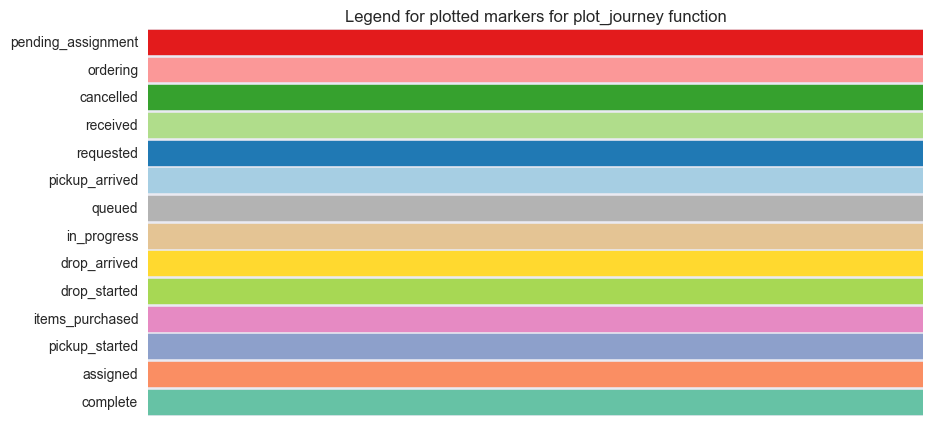

In [11]:
height = [0.9] * len(unique_states)
width = [1] * len(unique_states)

fig = plt.figure(figsize=[10, 5])

bars = plt.barh(bottom=np.arange(len(unique_states)), height=height, width=width, align='center')
for i, bar in enumerate(bars):
    bar.set_color(palette[i])
plt.ylim(-0.5, 13.5)
plt.yticks(range(len(unique_states)), unique_states)
plt.xticks([])
plt.title("Legend for plotted markers for plot_journey function")
plt.show()

In [12]:
plot_journey(df, key=102, radius=15)

Job has 818 GPS markers


We can clearly see that the majority of visible points on this map belong to either the `pickup_started` or `drop_started` states, which intuitively makes sense given these are the states in which we would expect our courier to be on the move. In fact, we can look at how many of these points actually belong to each state.

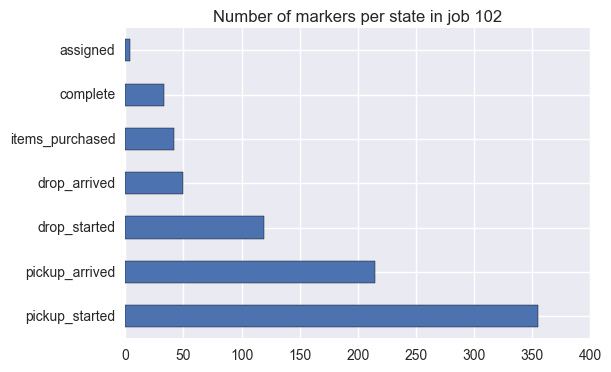

In [13]:
key = df.delivery_id.unique()[102]

df.loc[df.delivery_id == key, 'active_state'].value_counts().plot(kind='barh')
plt.title("Number of markers per state in job 102")
plt.show()

Despite seemingly dominating the map in terms of markers we can actually see, the `pickup_started` and `drop_started` states actually don't account for a reasonable chunk of our data. `drop_arrived` and `pickup_arrived` are also significant. However, we simply can't see these on the map because couriers in these states tend to not cover much distance.

Now let's discuss what we can actually achieve with this data. We have approximately sixteen million rows, each representing a point in time, four seconds ahead of the row above. This is equivalent to sixty-four million seconds of data, or one courier driving around London continuously for approximately two whole years! Given so much data, we might be able to uncover something about London's traffic system.

## Question: Can we predict traffic ahead of time?

Before we do anything, let's discuss motivation for this chosen modelling topic. Anyone who has driven in central London knows how disastrous the traffic can be. For logistics companies looking to optimise routing, identifying bottlenecks in traffic with foresight can be incredibly powerful, and profoundly impact the company's bottom line profit.

However, it's not quite as simple as presented above. As hinted at already, we have to account for all the time spent with couriers being stationary. When a courier is waiting for a few minutes for a customer to open the front door, we need to ensure that we are not inferring that this courier is stuck in traffic. So, before we embark on the modelling itself, we need to carve out a dataset for which we can safely say that each point represents a courier on the road, actually travelling to a destination. To do this, we explore which states are appropriate to include in our modelling.

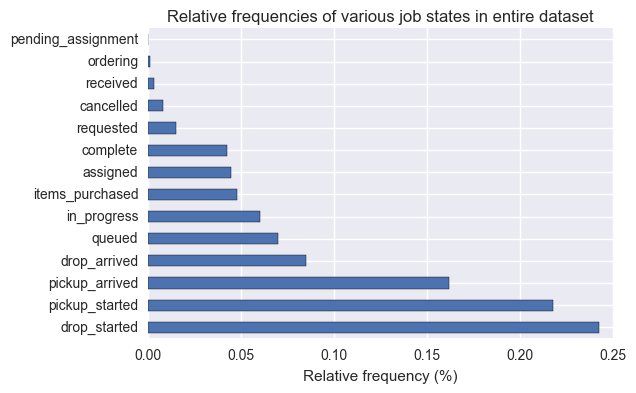

In [14]:
df.active_state.value_counts(normalize=True).plot(kind='barh')
plt.xlabel("Relative frequency (%)")
plt.title("Relative frequencies of various job states in entire dataset")
plt.show()

It is reassuring to see that `pickup_started` and `drop_started` are the most common states, and we know with reasonable certainty that these states represent couriers actually travelling. We can also be fairly confident that `pickup_arrived` and `drop_arrived` are inappropriate for traffic modelling, since couriers in this state are likely to be fairly stationary, as discussed above. However, we can also inspect how dense the GPS coordinates are in each state.

In [15]:
def plot_states(df):
    '''
    Plots all states as scatter plots for a given dataframe.
    '''
    global_centre = [df.lng.mean(), df.lat.mean()]
    global_range = [df.lng.var()**0.5, df.lat.var()**0.5]
    
    fig = plt.figure(figsize=(12, 35))
    
    for i, state in enumerate(df.active_state.unique()):
        
        data = df.loc[df.active_state == state]

        fig.add_subplot(7, 2, i+1)
        plt.scatter(data.lng, data.lat, alpha=0.5, s=0.1, color='b')
        plt.title(state)
        plt.axis('off')
        plt.xlim([global_centre[0] - global_range[0], global_centre[0] + global_range[0]])
        plt.ylim([global_centre[1] - global_range[1], global_centre[1] + global_range[1]])

CPU times: user 1min 6s, sys: 3.07 s, total: 1min 9s
Wall time: 1min 12s


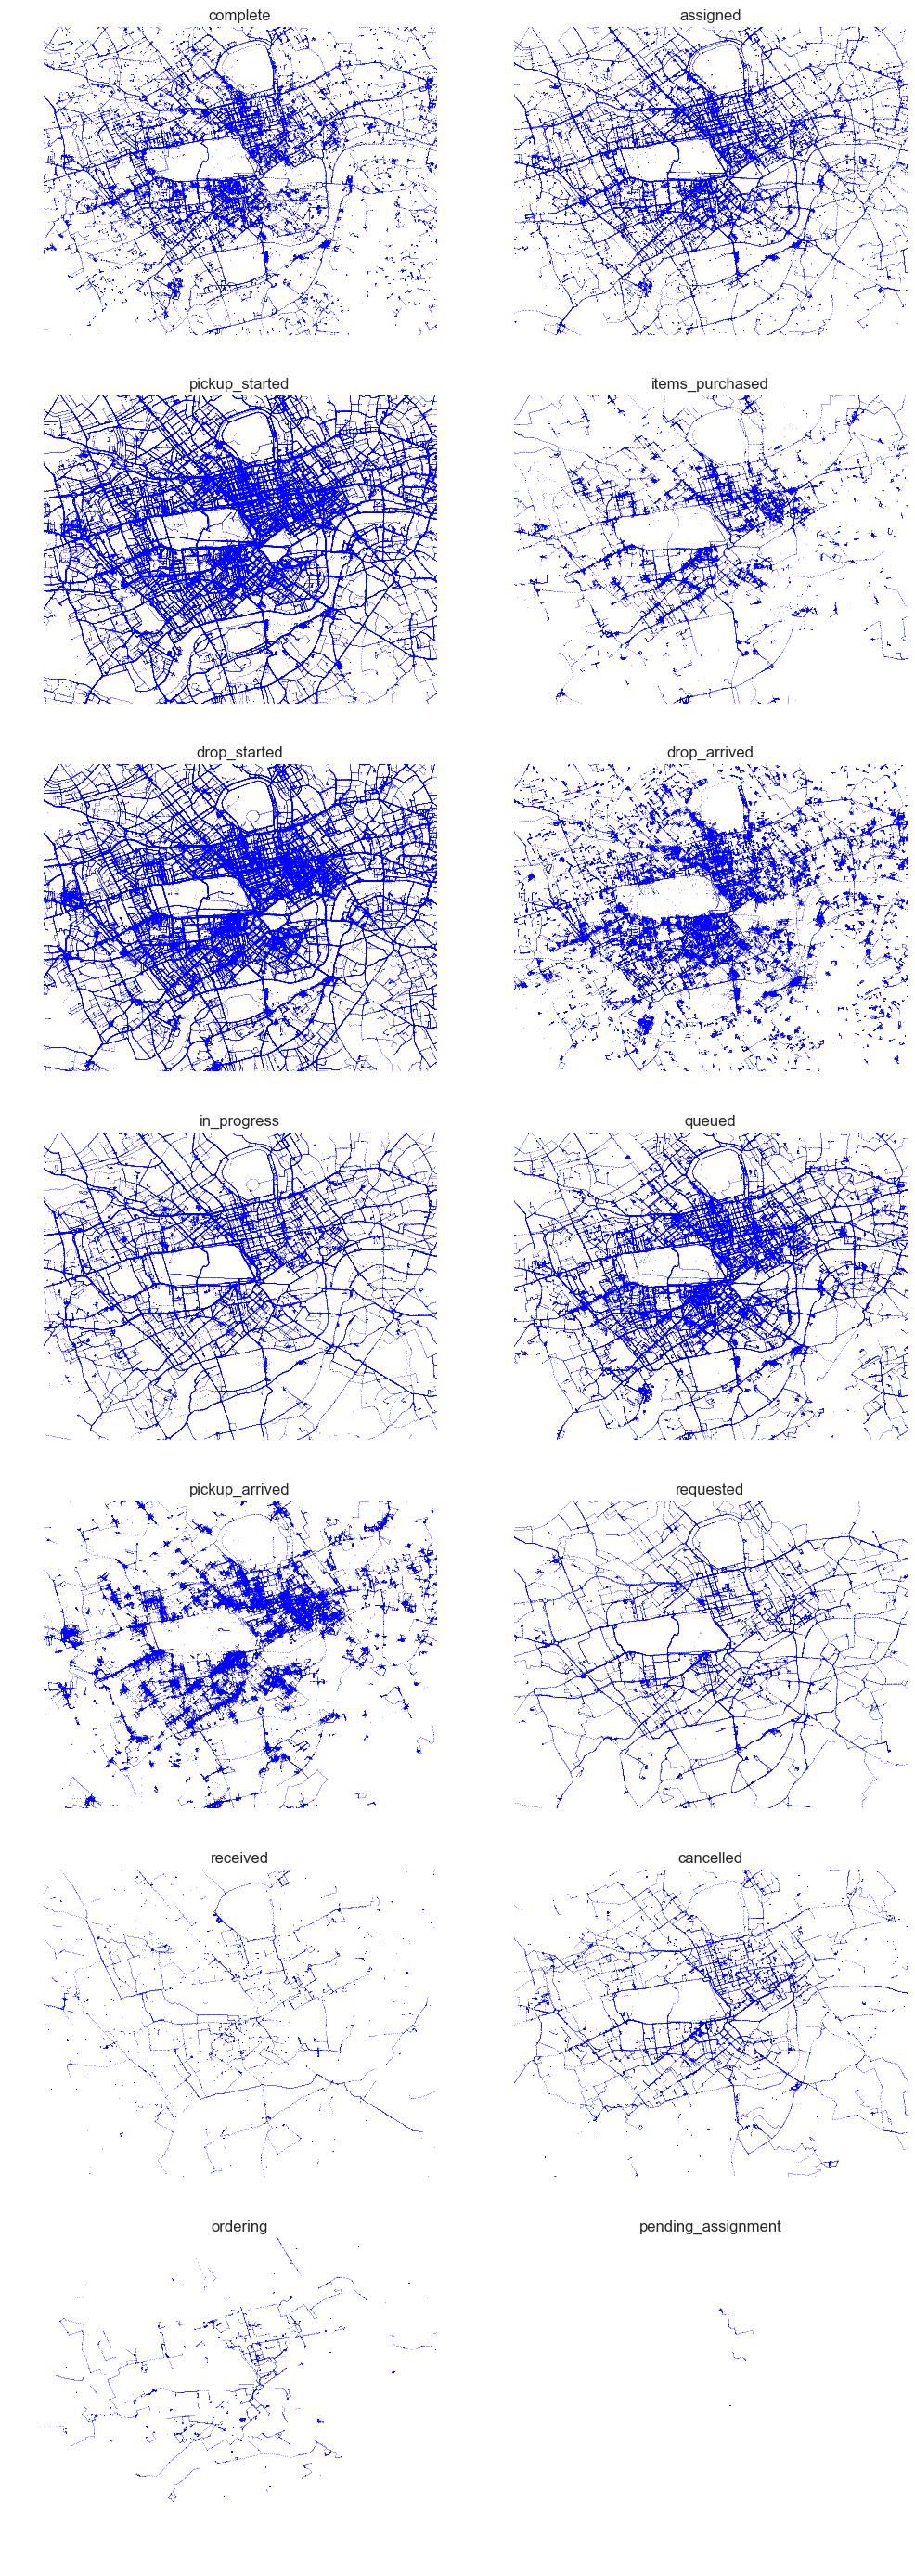

In [16]:
%%time
plot_states(df)

For the purposes of this project, the industry partner have advised that we only use the `pickup_started` and `drop_started` states, and since these represent almost half the data, we will still have a large corpus off which to learn.

In [17]:
%%time

states_to_keep = ['pickup_started', 'drop_started']

drop_indices = df.loc[~df.active_state.isin(states_to_keep)].index
df.drop(drop_indices, axis=0, inplace=True)
df.sort_values(['delivery_id', 'recorded_at'], inplace=True)
df.reset_index(inplace=True, drop=True)

CPU times: user 16.1 s, sys: 5.33 s, total: 21.4 s
Wall time: 23.6 s


Now, we need to formalise our definition of traffic. Intuitively, we should determine that a driver is in traffic if they fail to move by a certain distance over a certain time. This is something that is very easy to formalise and programme into our dataset. However, we need to be careful about the distance and time parameters we choose, for several reasons. First, we want our dataset to be fairly balanced and reflect the reality of driving in London. If drivers spend $1/3$ of their time on London roads in traffic, then our formalism should have this as an emergent property when applied to the data. Secondly, we need to allow for things like traffic lights, which can hold a driver hostage for, arguably, a minute, without this necessarily being "traffic". Below, we define traffic as moving less than 50 metres in 100 seconds. However, these parameters are clearly subjective, and research could be done simply to determine what the most appropriate definition is.

In [18]:
%%time
# we need to convert the time stamps to datetime format in order to manipulate them as we would like to
df.recorded_at = df.recorded_at.apply(pd.to_datetime)

CPU times: user 8min 6s, sys: 8.15 s, total: 8min 14s
Wall time: 8min 29s


In [19]:
def detect_traffic(df, row, lag, threshold):
    '''
    Returns a Boolean based on whether the driver, for a given row, is deemed to be in traffic, by
    detecting whether the driver has moved more than a threshold distance over a user specified time lag,
    or whether they will move more than that threshold distance in the same time period in the future.
    Inputs:
        - df: a dataframe, whose format conforms to the structure outlined in this notebook
        - row: a row of the dataframe
        - lag: float, specifying seconds to look back in the df. Must be greater than 2.0. Lag is
            rounded to the nearest 4 second interval.
        - threshold: float, specifying distance in metres that defines whether driver is in traffic
    Returns:
        - a boolean or np.NaN. The boolean determines whether the courier is in traffic for a given row.
    '''
    lag_steps = int(round(lag/4))
    num_data = len(df)
    
    if row.name >= lag_steps and row.name < num_data - lag_steps:
        last_step = df.iloc[row.name - lag_steps]
        next_step = df.iloc[row.name + lag_steps]
    else:
        return np.NaN
    
    last_bool, next_bool = [False, False], [False, False]
    
    cur_location = (row.lat, row.lng)
    if last_step.delivery_id == row.delivery_id:
        last_location = (last_step.lat, last_step.lng)
        distance = vincenty(cur_location, last_location).meters
        last_bool[0] = True
        last_bool[1] = distance < threshold
    if next_step.delivery_id == row.delivery_id:
        next_location = (next_step.lat, next_step.lng)
        distance = vincenty(cur_location, next_location).meters
        next_bool[0] = True
        next_bool[1] = distance < threshold

    if last_bool[0] and next_bool[0]:
        return int(last_bool[1] or next_bool[1])
    elif last_bool[0]:
        return int(last_bool[1])
    elif next_bool[0]:
        return int(next_bool[1])
    else:
        return np.NaN

Let's see how this looks on a test journey.

In [20]:
def plot_journey_traffic(df, key, radius, lag, threshold):
    '''
    This function plots all GPS coordinates associated with a given key on an interactive Folium map object.
    The function colour codes markers by whether the driver is in traffic.
    Inputs:
        - df: pd.DataFrame - a dataframe of the format specified at the beginning of this notebook.
        - radius: float - radius for plotted GPS markers.
        - key: int/string - if an integer, retrieves the n'th unique delivery_id, where n = key. If a string,
            it is assumed to be a string which matches a delivery_id in the df.
        - lag: as specified in detect_traffic
        - threshold: as specified in detect_traffic
    Returns:
        - map_journey: folium.Map - interactive map object, with job GPS coordinates plotted on the map
    '''
    if type(key) == int:
        all_ids = df.delivery_id.unique()
        key = all_ids[key]
    
    journey = df.loc[df.delivery_id == key]
        
    traffic_series = np.array(journey.apply(lambda x: detect_traffic(df, x, lag=lag, threshold=threshold), axis=1))
    coords = list(np.array(journey[['lat', 'lng']]))
    print("Job has {0:,d} GPS markers".format(len(coords)))
    
    centre_coords = [coords[0][0], coords[0][1]]
    
    map_journey = folium.Map(location=centre_coords, zoom_start=14, tiles="Cartodb Positron")
    
    # Adding GPS coordinates to map
    for i, coord in enumerate(coords):
        if traffic_series[i]:
            my_color = palette[-1]
        else:
            my_color = palette[0]
        
        folium.CircleMarker(
            location=[coord[0], coord[1]], 
            color=None, 
            fill_color=my_color,
            fill_opacity=1,
            radius=radius).add_to(map_journey)   
    
    return map_journey

In [21]:
plot_journey_traffic(df, key=51, radius=25, lag=100, threshold=50)

Job has 171 GPS markers


Green points denote not being in traffic, and red points denote being in traffic. We can clearly see one pressure point in the journey where traffic is present. Now, we build a binary classifier that tries to determine whether there will be traffic at a given location at a given time of day. For data security reasons, the data were provided to us with the date already scrambled, which means that we cannot use the day of the week as a feature. 

We create a cardinal direction feature below, which tells us whether the direction of travel is North or South, or East or West.

In [22]:
def determine_cardinal_direction(df, row, lag):
    '''
    This function determines cardinal direction of travel based on comparing one row's coordinates with another's.
    Inputs:
        - df: pandas dataframe conforming to structure outlined in this notebook
        - row: row of above df
        - lag: as specified in earlier functions
    Returns:
        - [north_south, east_west]: a list of strings, with north_south = 'N' or 'S' and east_west = 'E' or 'W'
    '''
    lag_steps = int(round(lag/4))
    num_data = len(df)
    
    if row.name >= lag_steps:
        last_step = df.iloc[row.name - lag_steps]
    else:
        return np.NaN
    
    cur_location = (row.lat, row.lng)
    if last_step.delivery_id == row.delivery_id:
        last_location = (last_step.lat, last_step.lng)
    else:
        return np.NaN
    
    if cur_location[0] > last_location[0]:
        north_south = 'N'
    else:
        north_south = 'S'
        
    if cur_location[1] > last_location[1]:
        east_west = 'E'
    else:
        east_west = 'W'
        
    return [north_south, east_west]

Now we apply the `detect_traffic` and `determine_cardinal_direction` functions to our data. Since the below feature extraction functions take one and two hours respectively to compute, the cells have been converted to markdown, and the pre-computed dataframe can be opened below.
```python
lag = 100
threshold = 50

df['traffic'] = df.apply(lambda x: detect_traffic(df, x, lag=lag, threshold=threshold), axis=1)
df['cardinal_direction'] = df.apply(lambda x: determine_cardinal_direction(df, x, lag=lag), axis=1)

# drop rows for which we do not have traffic or cardinal direction data
drop_indices = df.loc[df.traffic.isnull() | df.cardinal_direction.isnull()].index
df.drop(drop_indices, axis=0, inplace=True)
df.reset_index(inplace=True, drop=True)
```

Finally, for our temporal feature, we encode time of day as minutes past midnight.
```python
df['minutes'] = df.recorded_at.apply(lambda x: x.minute + 60.0*x.hour)
```

We can now load up our pre-computed data and inspect how many positive `traffic` labels we have.

In [23]:
%%time
df = pd.read_csv('data/tracking_locations_preprocessed.csv')

CPU times: user 20.7 s, sys: 3.24 s, total: 24 s
Wall time: 25.2 s


In [24]:
print("Traffic present in {0:.1f}% of data.".format(100*len(df.loc[df.traffic == 1]) / len(df)))

Traffic present in 30.7% of data.


Now let's take a look at what our formalism for traffic looks like graphically. On the below plot, traffic points are shown in red, while blue indicates points with no traffic present.

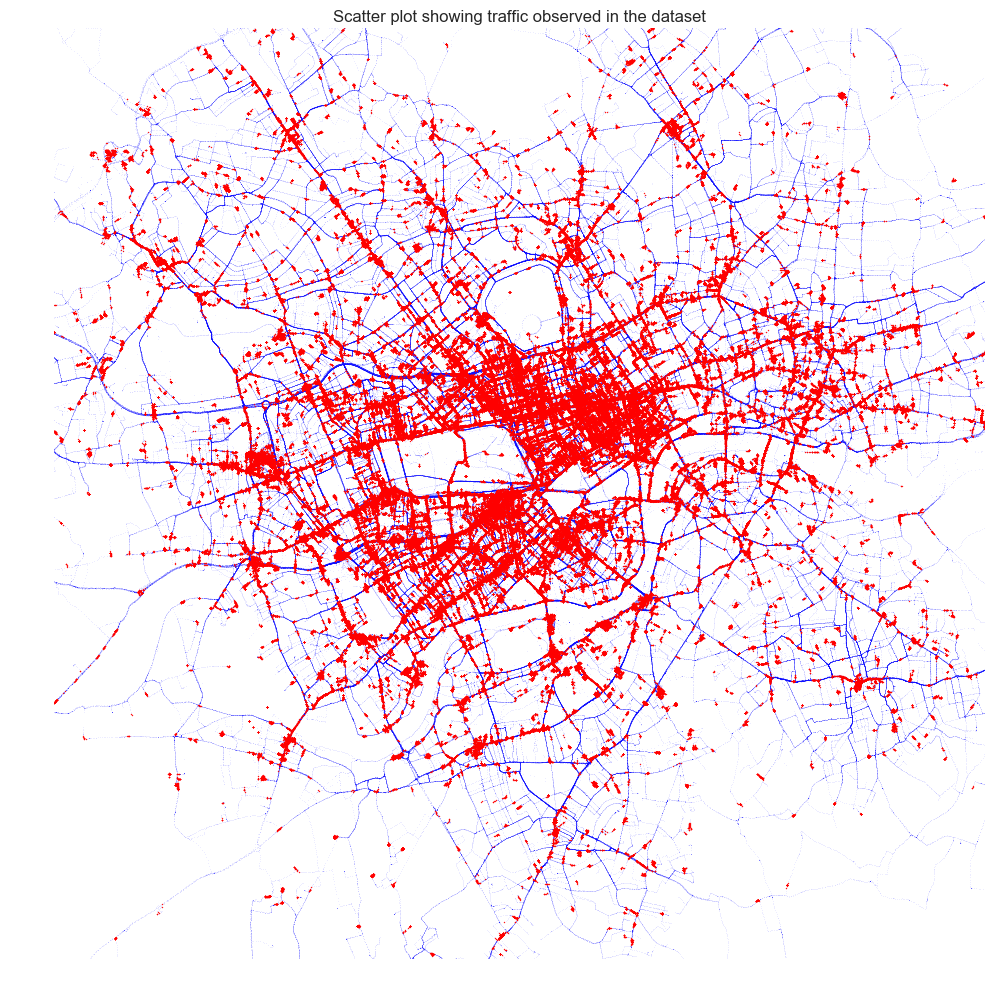

CPU times: user 37 s, sys: 1.15 s, total: 38.1 s
Wall time: 38.7 s


In [25]:
%%time

def plot_traffic(df):
    fig = plt.figure(figsize=[12, 12])

    df_traffic = df.loc[df.traffic == 1]
    df_clear = df.loc[df.traffic == 0]

    plot_centre = [df.lng.mean(), df.lat.mean()]
    plot_range = [df.lng.var()**0.4, df.lat.var()**0.4]

    plt.scatter(df_clear.lng, df_clear.lat, alpha=0.1, s=0.1, color='b')
    plt.scatter(df_traffic.lng, df_traffic.lat, alpha=0.9, s=0.5, color='r')
    plt.title('Scatter plot showing traffic observed in the dataset')
    plt.axis('off')
    plt.xlim([plot_centre[0] - plot_range[0], plot_centre[0] + plot_range[0]])
    plt.ylim([plot_centre[1] - plot_range[1], plot_centre[1] + plot_range[1]])
    plt.show()
    
plot_traffic(df)

As we would expect, the red seems to be clustered around central London and busy junctions. Can we use any individual feature to explain variation in the `traffic` labels?

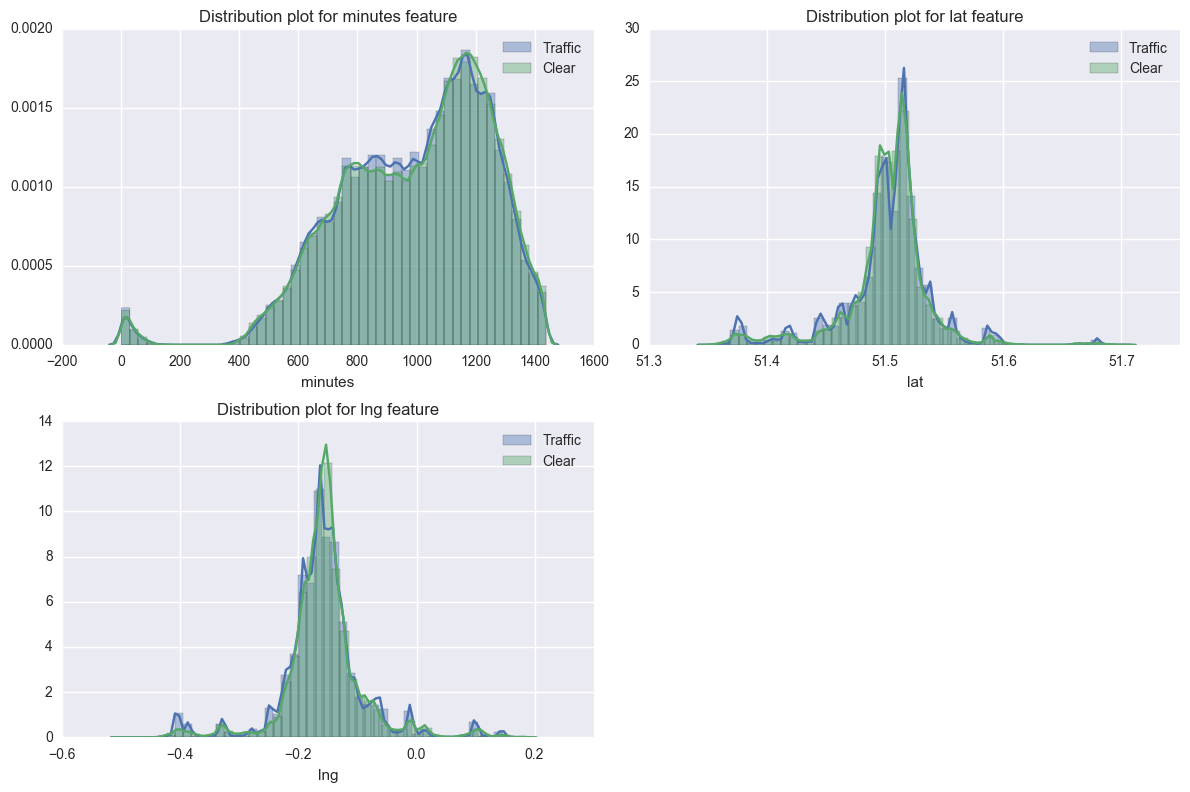

CPU times: user 50 s, sys: 23.4 s, total: 1min 13s
Wall time: 1min 14s


In [26]:
%%time
fig = plt.figure(figsize=[12,8])

features = ['minutes', 'lat', 'lng', 'north_south', 'east_west']

for i, feature in enumerate(features[:3]):
    ax = fig.add_subplot(2,2,i+1)
    sns.distplot(df.loc[df.traffic == 1, feature], label='Traffic')
    sns.distplot(df.loc[df.traffic == 0, feature], label="Clear")
    plt.title("Distribution plot for {} feature".format(feature))
    plt.legend()
        
plt.tight_layout()
plt.show()

We can see above that it's very difficult to find any difference between the `traffic` and `clear` distributions for the three plotted features by visual inspection. What about `cardinal_direction`?

In [27]:
%%time
# convert the cardinal_direction column from string type to list type
df.cardinal_direction = df.cardinal_direction.apply(eval)

CPU times: user 1min 25s, sys: 1.94 s, total: 1min 26s
Wall time: 1min 28s


In [28]:
%%time
# split out cardinal_direction into two binary features
df['north_south'] = df.cardinal_direction.apply(lambda x: x[0])
df['east_west'] = df.cardinal_direction.apply(lambda x: x[1])

CPU times: user 3.75 s, sys: 110 ms, total: 3.86 s
Wall time: 3.95 s


In [29]:
prop_north_traffic = len(df.loc[(df.traffic == 1) & (df.north_south == 'N')]) / len(df.loc[df.traffic == 1])
prop_north_clear = len(df.loc[(df.traffic == 0) & (df.north_south == 'N')]) / len(df.loc[df.traffic == 0])
prop_east_traffic = len(df.loc[(df.traffic == 1) & (df.east_west == 'E')]) / len(df.loc[df.traffic == 1])
prop_east_clear = len(df.loc[(df.traffic == 0) & (df.east_west == 'E')]) / len(df.loc[df.traffic == 0])

print("{0:.2f}% of traffic data is cardinality North, but {1:.2f}% of clear data is cardinality North".\
      format(100*prop_north_traffic, 100*prop_north_clear))
print("{0:.2f}% of traffic data is cardinality East, but {1:.2f}% of clear data is cardinality East".\
      format(100*prop_east_traffic, 100*prop_east_clear))

43.22% of traffic data is cardinality North, but 49.58% of clear data is cardinality North
44.35% of traffic data is cardinality East, but 51.25% of clear data is cardinality East


Interestingly, traffic data seem to be more prevalent when couriers are heading South and West, since North and East cardinalities are more common in the clear data (where there is no traffic).

Now we scale our data to ensure comparable distributions across features. For the `north_south` and `east_west` features, we must also encode the labels (`'N'`, `'S'`, etc.) into numbers.

In [30]:
SS = []

features_SS = features[:3]
features_LE = features[3:]

for feature in features_SS:
    ss = StandardScaler()
    df[feature + '_feature'] = ss.fit_transform(df[feature])
    SS.append(ss)
    
LE = []

for feature in features_LE:
    le = LabelEncoder()
    df[feature + '_feature'] = le.fit_transform(df[feature])
    LE.append(le)
    
    ss = StandardScaler()
    df[feature + '_feature'] = ss.fit_transform(df[feature + '_feature'])
    SS.append(ss)

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/preprocessing/data.py:586: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/preprocessing/data.py:649: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/preprocessing/data.py:586: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and wil

Now let's preview the `df`, filtered by the columns we actually care about.

In [31]:
features_processed = [feature + '_feature' for feature in features]

df[features_processed + ['traffic']].head()

,minutes_feature,lat_feature,lng_feature,north_south_feature,east_west_feature,traffic
0,0.357685,0.379431,0.476080,0.953617,-1.017539,1.0
1,0.357685,0.379431,0.476080,0.953617,-1.017539,1.0
2,0.357685,0.379431,0.476080,0.953617,-1.017539,1.0
3,0.357685,0.380455,0.476655,-1.048639,-1.017539,1.0
4,0.357685,0.382029,0.476920,-1.048639,-1.017539,1.0


Everything seems to be in order, so we can now get started with modelling our data! We need to first split our data into train and test sets. However, we need to approach this splitting process with care. A popular way of doing this split is to shuffle all our data points and then draw a dividing line 80% of the way down our shuffled list of data. However, in this case, that would be detrimental to the real life deployment value of our modelling. The reason for this is that our data consists of approximately 20,000 deliveries. If we shuffle all our data points, it's likely that many of those deliveries will have data points in both the training and test sets. Our data is such that if a courier is in traffic at a given point in time and space, they're likely to be in traffic at the next point in time. If those two rows in our data set are split between train and test, the model is going to perform deceptively well on our test set, since much of the test set will already effectively have been seen in the training set. Therefore, it's vital to separate our data by journeys, because we'll then be testing the model on completely unseen journeys.

In [32]:
all_ids = df.delivery_id.unique()
test_size = 0.2 # test set 20% of total data

shuffle(all_ids)

test_ids = all_ids[:int(round(test_size * len(all_ids)))]

In [33]:
print("Size of test set: {0:.1f}% of total data".format(100*len(df.loc[df.delivery_id.isin(test_ids)]) / len(df)))

Size of test set: 20.1% of total data


In [34]:
df_test = df.loc[df.delivery_id.isin(test_ids)]

drop_indices = df.loc[df.delivery_id.isin(test_ids)].index
df.drop(drop_indices, axis=0, inplace=True)
df.reset_index(inplace=True, drop=True)

To properly assess how well our machines are learning, we need to build cross validation functionality in a similar way to how we carved out the test set.

In [35]:
def build_CV(df, folds):
    '''
    Given a dataframe, this function provides train/development set splits, indexed by delivery_id
    Inputs:
        - df: a pandas dataframe conforming to the structure presented in this notebook
        - folds: integer - number of folds for our cross validation
    Returns:
        - splits: a list, each element of which is a train/dev split.
    '''
    all_ids = df.delivery_id.unique()
    dev_size = 1 / folds
    splits = []
    
    shuffle(all_ids)
    
    for i in range(folds):
        split_index_start = int(round(i * dev_size * len(all_ids)))
        split_index_end = int(round((i+1) * dev_size * len(all_ids)))
        dev_split = all_ids[split_index_start: split_index_end]
        train_split = [ID for ID in all_ids if ID not in dev_split]
        split = [train_split, dev_split]
        splits.append(split)
        
    return splits

In [36]:
CV = build_CV(df, 5)

In [37]:
%%time
# train set sizes as a proportion of total number of data points
print("Fold  |  Train size  |  Dev size\n" + '-'*32)
for i, cv in enumerate(CV):
    train_len = 100*len(df.loc[df.delivery_id.isin(cv[0])]) / len(df)
    dev_len = 100*len(df.loc[df.delivery_id.isin(cv[1])]) / len(df)
    print("  {2}   |    {0:.2f}%    |   {1:.2f}%".format(train_len, dev_len, i))

Fold  |  Train size  |  Dev size
--------------------------------
  0   |    80.57%    |   19.43%
  1   |    79.83%    |   20.17%
  2   |    80.00%    |   20.00%
  3   |    79.70%    |   20.30%
  4   |    79.91%    |   20.09%
CPU times: user 6.91 s, sys: 2.24 s, total: 9.15 s
Wall time: 9.23 s


As expected, training set sizes are all very close to 80%, and all dev sets are close to 20%. Now we need to select some models, have them learn on our training sets and evaluated on their respective development sets.

In [38]:
def perform_CV(df, features, model, CV, scoring_1, scoring_2=None, verbose=True):
    '''
    Performs cross-validation for one model
    Inputs:
        - df: pandas dataframe conforming to structure outlined in this notebook
        - features: list of strings, corresponding to df column names
        - model: an sklearn model object
        - CV: a list, each element of which is a train/dev split, as output by the build_CV function
        - scoring_1, scoring_2: sklearn scoring functions
        - verbose: boolean, determining whether output is printed
    Returns:
        - means of scoring functions evaluated on all train/dev splits
    '''
    scores = []
    scores_2 = []
    
    for i, ix in enumerate(CV):
        tic = time.time()
        
        df_train = df.loc[df.delivery_id.isin(ix[0])]
        df_dev = df.loc[df.delivery_id.isin(ix[1])]
        
        X_train = df_train[features]
        y_train = df_train['traffic']
        X_dev = df_dev[features]
        y_true = df_dev['traffic']
        
        y_pred = model.fit(X_train, y_train).predict(X_dev)
        
        score = scoring_1(y_true, y_pred)
        scores.append(score)
        
        if scoring_2:
            score_2 = scoring_2(y_true, y_pred)
            scores_2.append(score_2)
            
        toc = time.time()
        
        if verbose:
            if scoring_2:
                print("Iteration: {0:>2d}  |  Dev score 1: {1:.1f}%  |  Dev score 2: {2:.1f}%  |  Time: {3:.0f}s".\
                      format(i+1, 100*score, 100*score_2, toc-tic)) 
            else:
                print("Iteration: {0:>2d}  |  Dev score: {1:.1f}%  |  Time: {2:.0f}s".format(i+1, 100*score, toc-tic))
    
    if scoring_2:
        return np.mean(scores), np.mean(scores_2)
    else:
        return np.mean(scores)

We need to choose how we would like to assess accuracy. We use precision and accuracy, two popular metrics for binary classification (more discussion on these later). We also use a vanilla random forest classifier first as this is typically a fairly powerful classifier.

In [39]:
features_scaled = [feature + '_feature' for feature in features]

In [40]:
perform_CV(df, features_scaled, RandomForestClassifier(), CV, precision_score, recall_score)

Iteration:  1  |  Dev score 1: 80.0%  |  Dev score 2: 31.7%  |  Time: 135s
Iteration:  2  |  Dev score 1: 80.1%  |  Dev score 2: 31.0%  |  Time: 149s
Iteration:  3  |  Dev score 1: 78.5%  |  Dev score 2: 30.2%  |  Time: 145s
Iteration:  4  |  Dev score 1: 78.9%  |  Dev score 2: 29.9%  |  Time: 146s
Iteration:  5  |  Dev score 1: 78.5%  |  Dev score 2: 30.1%  |  Time: 138s


(0.79193822088110677, 0.30565998905566094)

In [40]:
# hard coding in final results of cell above for comparing against other baseline models
RF_scores = [0.7919, 0.3056]

It's always good to run a dummy classifier on our data to get an idea of reasonable benchmark performance.

In [41]:
%%time
dummy_strategies = [
    'stratified',
    'most_frequent',
    'prior',
    'uniform'
]

dummy_models = [DummyClassifier(strategy=strategy) for strategy in dummy_strategies]
dummy_scores = []

for model in dummy_models:
    precision, recall = perform_CV(df, features_scaled, model, CV, precision_score, recall_score, verbose=False)
    dummy_scores.append((precision, recall))

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


CPU times: user 51.4 s, sys: 28.5 s, total: 1min 19s
Wall time: 1min 31s


In [42]:
for scores, strategy in zip(dummy_scores, dummy_strategies):
    print("Strategy: {0:<13}  |  Precision: {1:>6.2f}%  |  Recall: {2:>6.2f}%".\
          format(strategy, 100*scores[0], 100*scores[1]))

Strategy: stratified     |  Precision:  30.64%  |  Recall:  30.63%
Strategy: most_frequent  |  Precision:   0.00%  |  Recall:   0.00%
Strategy: prior          |  Precision:   0.00%  |  Recall:   0.00%
Strategy: uniform        |  Precision:  30.65%  |  Recall:  50.05%


We can attain 31% precision and 50% recall by predicting traffic for half of all instances at random. Our earlier random forest example shows that we can easily achieve high precision, but that we are not as strong on recall. Does this matter? High precision and low recall means that we rarely predict positive labels, but when we do, we're generally correct. Conversely, high recall and low precision means that we don't miss many positive labels, but we also have lots of false positives. This is arguably worse than not having a model at all, since we might waste a lot of time avoiding clear roads that our model predicted would be chock-a-block. It boils down to the utility of a missed positive traffic label versus the utility of a false alarm. This is something that a user of such a model should be able to quantify in economic terms. Thie project assumes from this point that high precision is more valuable than high accuracy.

With this in mind, we now run a few more baseline models, where baseline performance is with no hyperparameter optimisation. We only train and validate each model on one training/validation set to save time, but ideally we would perform full cross-validation.

In [43]:
def validate_model(df, features, model, CV, scoring_1, scoring_2=None, verbose=True):
    '''
    Performs the same function as perform_CV, but assesses on one train/dev split
    Inputs:
        - df: pandas dataframe conforming to structure outlined in this notebook
        - features: list of strings, corresponding to df column names
        - model: an sklearn model object
        - CV: a list, each element of which is a train/dev split, as output by the build_CV function
        - scoring_1, scoring_2: sklearn scoring functions
        - verbose: boolean, determining whether output is printed
    Returns:
        - scores of model on single train/dev pair
    '''
    tic = time.time()
    
    train_indices = CV[0][0]
    val_indices = CV[0][1]
    
    df_train = df.loc[df.delivery_id.isin(train_indices)]
    df_dev = df.loc[df.delivery_id.isin(val_indices)]

    X_train = df_train[features]
    y_train = df_train['traffic']
    X_dev = df_dev[features]
    y_true = df_dev['traffic']

    y_pred = model.fit(X_train, y_train).predict(X_dev)

    score = scoring_1(y_true, y_pred)

    if scoring_2:
        score_2 = scoring_2(y_true, y_pred)

    toc = time.time()

    if verbose:
        if scoring_2:
            print("Dev score 1: {0:.1f}%  |  Dev score 2: {1:.1f}%  |  Time: {2:.0f}s".\
                  format(100*score, 100*score_2, toc-tic)) 
        else:
            print("Dev score: {0:.1f}%  |  Time: {1:.0f}s".format(100*score, toc-tic))
    
    if scoring_2:
        return score, score_2
    else:
        return score

In [45]:
baseline_models = [
    LogisticRegression(),
    AdaBoostClassifier(),
    KNeighborsClassifier()
]

baseline_scores = []
baseline_names = [
    'Logistic Regression',
    'AdaBoost',
    'K Nearest Neighbours',
]

for i, model in enumerate(baseline_models):
    tic = time.time()
    precision, recall = validate_model(df, features_scaled, model, CV, precision_score, recall_score, verbose=False)
    baseline_scores.append((precision, recall))
    toc = time.time()
    print("Model: {0:<20}  |  Precision: {1:>6.2f}%  |  Recall: {2:>6.2f}%  |  Time: {3:.0f}s"\
          .format(baseline_names[i], 100*precision, 100*recall, toc-tic))

print("Model: {0:<20}  |  Precision: {1:>6.2f}%  |  Recall: {2:>6.2f}%  |  Time: N/A"\
      .format('Random Forest', 100*RF_scores[0], 100*RF_scores[1]))

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Model: Logistic Regression   |  Precision:   0.00%  |  Recall:   0.00%  |  Time: 7s
Model: AdaBoost              |  Precision:  65.81%  |  Recall:   3.90%  |  Time: 172s
Model: K Nearest Neighbours  |  Precision:  56.17%  |  Recall:  39.75%  |  Time: 267s
Model: Random Forest         |  Precision:  79.57%  |  Recall:  30.83%  |  Time: N/A


We now take the random forest classifier forward and optimise hyperparameters. Again, to save time, we validate each parameter on only one train/dev split.

In [46]:
params = [5, 7, 10, 14, 20]

for param in params:
    tic = time.time()
    model = RandomForestClassifier(n_estimators=param)
    precision, recall = validate_model(df, features_scaled, model, CV, precision_score, recall_score, verbose=False)
    toc = time.time()
    print("n_estimators: {0:<2}  |  Precision: {1:>6.2f}%  |  Recall: {2:>6.2f}%  |  Time: {3:.0f}s"\
          .format(param, 100*precision, 100*recall, toc-tic))

n_estimators: 5   |  Precision:  75.17%  |  Recall:  36.56%  |  Time: 73s
n_estimators: 7   |  Precision:  75.80%  |  Recall:  34.54%  |  Time: 108s
n_estimators: 10  |  Precision:  79.94%  |  Recall:  31.70%  |  Time: 139s
n_estimators: 14  |  Precision:  80.82%  |  Recall:  32.09%  |  Time: 185s
n_estimators: 20  |  Precision:  81.40%  |  Recall:  32.85%  |  Time: 246s


Gains in performance seem limited as we increase `n_estimators` beyond `10`, and are not commensurate with extra computation time, so from here, we use `n_estimators = 10`, which is the default value. Now that we have established our best performing model, we can look at feature importance under this model. We do this by examining how well the model performs by removing each feature. 

In [47]:
feature_sets = [[feature for feature in features_scaled if feature != exc_feature] for exc_feature in features_scaled]

model = RandomForestClassifier()

for i, feature_set in enumerate(feature_sets):
    tic = time.time()
    precision, recall = validate_model(df, feature_set, model, CV, precision_score, recall_score, verbose=False)
    toc = time.time()
    print("Missing feature: {0:<11}  |  Precision: {1:>6.2f}%  |  Recall: {2:>6.2f}%  |  Time: {3:.0f}s"\
          .format(features[i], 100*precision, 100*recall, toc-tic))

Missing feature: minutes      |  Precision:  78.50%  |  Recall:  46.01%  |  Time: 145s
Missing feature: lat          |  Precision:  46.36%  |  Recall:  19.36%  |  Time: 119s
Missing feature: lng          |  Precision:  45.03%  |  Recall:  19.80%  |  Time: 112s
Missing feature: north_south  |  Precision:  83.19%  |  Recall:  29.84%  |  Time: 135s
Missing feature: east_west    |  Precision:  82.68%  |  Recall:  28.84%  |  Time: 137s


Clearly, removing actual location coordinates is detrimental to performance. However, we can also note that the `cardinal_direction` features seem to be _decreasing_ precision when included, but they also improve recall marginally. Interestingly, removing the temporal feature significantly improves recall, but slightly reduces our precision. Finally, we can deploy this model on our test set.

In [44]:
%%time
model = RandomForestClassifier()

X_train = df[features_scaled]
y_train = df['traffic']

X_test = df_test[features_scaled]
y_true = df_test['traffic']

y_pred = model.fit(X_train, y_train).predict(X_test)

precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)

print("Test set precision: {0:.2f}%  |  Test set recall: {1:.2f}%".format(100*precision, 100*recall))

Test set precision: 80.35%  |  Test set recall: 32.01%
CPU times: user 2min 31s, sys: 4.35 s, total: 2min 36s
Wall time: 2min 40s


Performance is in line with expectations. While we only manage to identify approximately a third of true traffic labels, we predict them without much error, as indicated by high precision. This prompts us to conclude that yes, we can predict traffic for unseen journeys using this data.

We can also plot these predicted traffic points versus the true traffic points and see whether anything interesting arises.

In [45]:
df_test['pred'] = y_pred

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


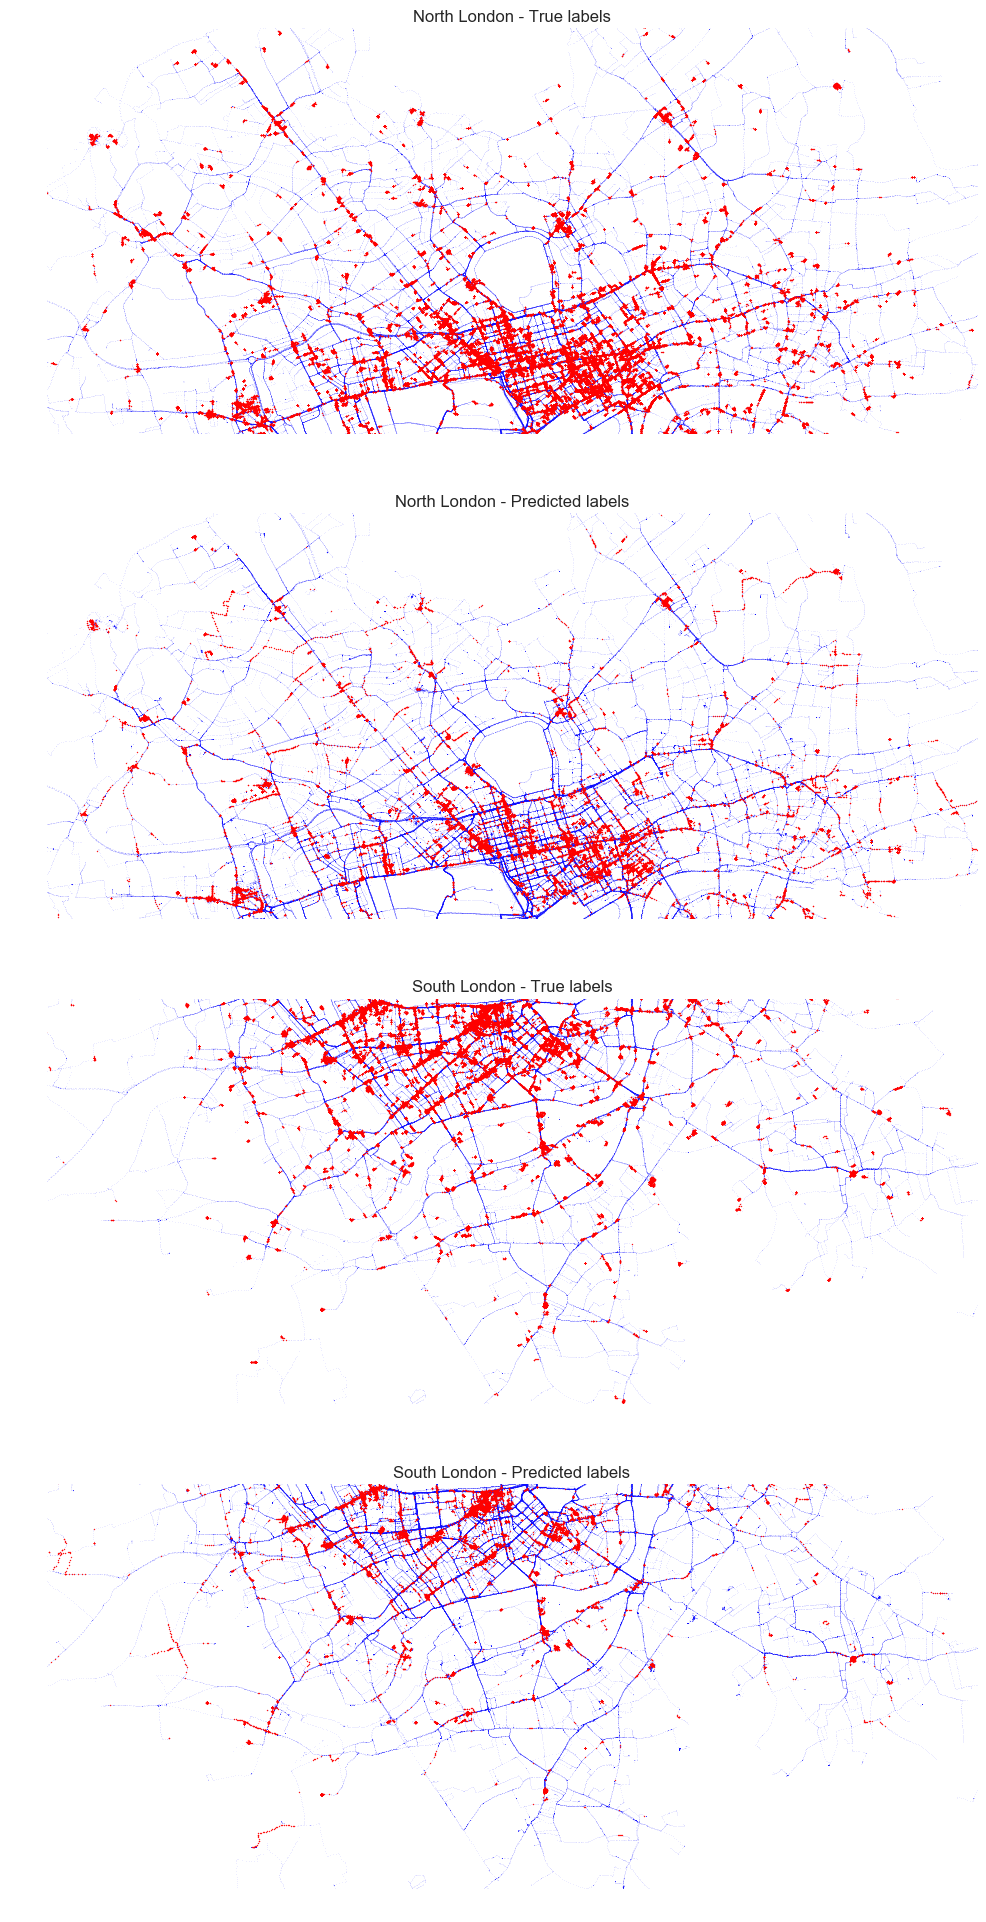

CPU times: user 30.3 s, sys: 1.07 s, total: 31.4 s
Wall time: 32.3 s


In [46]:
%%time
fig = plt.figure(figsize=[12, 24])

df_traffic_true = df_test.loc[df_test.traffic == 1]
df_traffic_pred = df_test.loc[df_test.pred == 1]
df_clear_true = df_test.loc[df_test.traffic == 0]
df_clear_pred = df_test.loc[df_test.pred == 0]

plot_centre = [df_test.lng.mean(), df_test.lat.mean()]
plot_range = [df_test.lng.var()**0.4, df_test.lat.var()**0.4]

fig.add_subplot(4,1,1)
plt.scatter(df_clear_true.lng, df_clear_true.lat, alpha=0.1, s=0.1, color='b')
plt.scatter(df_traffic_true.lng, df_traffic_true.lat, alpha=0.9, s=0.5, color='r')
plt.title('North London - True labels')
plt.axis('off')
plt.xlim([plot_centre[0] - plot_range[0], plot_centre[0] + plot_range[0]])
plt.ylim([plot_centre[1], plot_centre[1] + plot_range[1]])

fig.add_subplot(4,1,2)
plt.scatter(df_clear_pred.lng, df_clear_pred.lat, alpha=0.1, s=0.1, color='b')
plt.scatter(df_traffic_pred.lng, df_traffic_pred.lat, alpha=0.9, s=0.5, color='r')
plt.title('North London - Predicted labels')
plt.axis('off')
plt.xlim([plot_centre[0] - plot_range[0], plot_centre[0] + plot_range[0]])
plt.ylim([plot_centre[1], plot_centre[1] + plot_range[1]])

fig.add_subplot(4,1,3)
plt.scatter(df_clear_true.lng, df_clear_true.lat, alpha=0.1, s=0.1, color='b')
plt.scatter(df_traffic_true.lng, df_traffic_true.lat, alpha=0.9, s=0.5, color='r')
plt.title('South London - True labels')
plt.axis('off')
plt.xlim([plot_centre[0] - plot_range[0], plot_centre[0] + plot_range[0]])
plt.ylim([plot_centre[1] - plot_range[1], plot_centre[1]])

fig.add_subplot(4,1,4)
plt.scatter(df_clear_pred.lng, df_clear_pred.lat, alpha=0.1, s=0.1, color='b')
plt.scatter(df_traffic_pred.lng, df_traffic_pred.lat, alpha=0.9, s=0.5, color='r')
plt.title('South London - Predicted labels')
plt.axis('off')
plt.xlim([plot_centre[0] - plot_range[0], plot_centre[0] + plot_range[0]])
plt.ylim([plot_centre[1] - plot_range[1], plot_centre[1]])

plt.show()

As is potentially to be expected, our model is good at identifying traffic hotspots at fairly critical locations, such as junctions, but does miss a lot of points further from central London.

Thus, we have a model that can fairly precisely predict when and where traffic will occur in Central London for completely unseen journeys. Of course, there are limitations to this approach.

- Road networks evolve over time, and thus the efficacy of this model in deployment would heavily rely on some sort of regular online updating based on more recent journeys. 
- The usefulness of this model alone is limited, for all it does is indicate presence of traffic. Building a system that can use this output to actually generate routes for couriers would be a complex project in its own right.
- While useful for the industry partner, usefulness is limited for general traffic, given that drivers may be operating 2-wheeled vehicles, which are able to skip a lot of traffic.
- Dates being scrambled means we cannot use day of the week, which may add to predictive power. We could have also used weather data, had the real dates been provided.

Those wishing to further this analysis may want to deploy deep learning techniques on this corpus or apply techniques explored in this analysis to other cities.

## <font color='grey'>Appendix I - Meta data

- __keys__
 - `delivery_id` - the unique id assigned to one particular delivery job.
 - `driver_id` - the unique driver id of the driver who carried out that delivery.
- __time__
 - `recorded_at` - the timestamp corresponding to that particular GPS tracking location. For data security reasons, the data were provided to us with the date already scrambled. However, the time of day component of `recorded_at` is faithful to the true time originally recorded.
- __state__
 - `active_state` - the state of the job for that timestamp and GPS data.
- __location__
 - `lat` - latitude
 - `lng` - longitude
- __other spatial__
 - `accuracy` - a measure of accuracy of the `lat` and `lng` coordinates, provided by Apple.
 - `speed` & `heading` - measures of speed and heading provided by Apple.

## <font color='grey'>Appendix II - Required libraries

Standard packages used:

- csv
- random
- datetime
- time

Non-standard required packages:

- pandas (0.19.0)
- numpy (1.11.2)
- folium (0.2.1)
- geopy (1.11.0)
- seaborn (0.7.1)
- matplotlib (1.5.3)
- sklearn (0.18)

## <font color='grey'>Appendix III - Random Forest assessed on all train/dev splits
```
Iteration:  1  |  Dev score 1: 80.0%  |  Dev score 2: 31.7%  |  Time: 135s
Iteration:  2  |  Dev score 1: 80.1%  |  Dev score 2: 31.0%  |  Time: 149s
Iteration:  3  |  Dev score 1: 78.5%  |  Dev score 2: 30.2%  |  Time: 145s
Iteration:  4  |  Dev score 1: 78.9%  |  Dev score 2: 29.9%  |  Time: 146s
Iteration:  5  |  Dev score 1: 78.5%  |  Dev score 2: 30.1%  |  Time: 138s
```

## <font color='grey'>Appendix IV - Baseline model performance
```
Model: Logistic Regression   |  Precision:   0.00%  |  Recall:   0.00%  |  Time: 7s
Model: AdaBoost              |  Precision:  65.81%  |  Recall:   3.90%  |  Time: 172s
Model: K Nearest Neighbours  |  Precision:  56.17%  |  Recall:  39.75%  |  Time: 267s
Model: Random Forest         |  Precision:  79.19%  |  Recall:  30.56%  |  Time: N/A
```

## <font color='grey'>Appendix V - Random Forest Cross Validation
```
n_estimators: 5   |  Precision:  75.17%  |  Recall:  36.56%  |  Time: 73s
n_estimators: 7   |  Precision:  75.80%  |  Recall:  34.54%  |  Time: 108s
n_estimators: 10  |  Precision:  79.94%  |  Recall:  31.70%  |  Time: 139s
n_estimators: 14  |  Precision:  80.82%  |  Recall:  32.09%  |  Time: 185s
n_estimators: 20  |  Precision:  81.40%  |  Recall:  32.85%  |  Time: 246s
```

## <font color='grey'>Appendix VI - Missing feature analysis
```
Missing feature: minutes      |  Precision:  78.50%  |  Recall:  46.01%  |  Time: 145s
Missing feature: lat          |  Precision:  46.36%  |  Recall:  19.36%  |  Time: 119s
Missing feature: lng          |  Precision:  45.03%  |  Recall:  19.80%  |  Time: 112s
Missing feature: north_south  |  Precision:  83.19%  |  Recall:  29.84%  |  Time: 135s
Missing feature: east_west    |  Precision:  82.68%  |  Recall:  28.84%  |  Time: 137s
```